In [1]:
import numpy as np
import pandas as pd
import altair as alt
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import VotingRegressor, ExtraTreesRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

import os
for (dirname, _, filenames) in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/widsdatathon2022/train.csv
/kaggle/input/widsdatathon2022/test.csv
/kaggle/input/widsdatathon2022/sample_solution.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/widsdatathon2022/train.csv')
test_df = pd.read_csv('/kaggle/input/widsdatathon2022/test.csv')


In [3]:
train_df = train_df.query("State_Factor != 'State_6'")

In [4]:
replace = dict(zip([
    'Education_.*',
    '.*(f|F)ood_.*',
    'Health_Care_.*',
    'Lodging_.*',
    'Office_.*',
    '(Public_|Religious).*',
    'Retail_.*',
    'Service_.*',
    'Warehouse_.*',
    '.*_Unit_.*',
    'Mixed_Use_.*',
    ], [
    'Commercial_Education',
    'Commercial_Food',
    'Commercial_Health',
    'Commercial_Hotel',
    'Commercial_Office',
    'Commercial_Public',
    'Commercial_Retail',
    'Commercial_Service',
    'Commercial_Warehouse',
    'Residential_Unit',
    'Residential_Mixed',
    ]))

replace.update({
    'Commercial_Unknown': 'Commercial_Other',
    'Data_Center': 'Commercial_DC',
    'Industrial': 'Commercial_Industrial',
    'Laboratory': 'Commercial_Lab',
    'Nursing_Home': 'Commercial_Home',
    'Parking_Garage': 'Commercial_Parking',
    'Multifamily_Uncategorized': 'Residential_Multifamily',
    })

train_df['building_class'] = train_df['facility_type'].replace(replace,
        regex=True)
test_df['building_class'] = test_df['facility_type'].replace(replace,
        regex=True)

In [5]:
year = train_df["year_built"].fillna(2016)
train_df = train_df.loc[(year <= 2016) & (year >= 1845)]

In [6]:
# Making a new column by concating specific columns of df

def make_building_ids(data, columns):
    full_col_name = None
    for column in columns:
        if full_col_name is None:
            full_col_name = data[column].astype(str)
        else:
            full_col_name += '_' + data[column].astype(str)
    return full_col_name


buidling_columns = ['State_Factor', 'building_class', 'facility_type',
                    'year_built', 'floor_area']

train_df['building_ID'] = make_building_ids(train_df, buidling_columns)
test_df['building_ID'] = make_building_ids(test_df, buidling_columns)

In [7]:
# Categorical encoding by mean values
# Attribution: Inspired from another notebook in the competition

state_factor = train_df["State_Factor"]

train_df["State_Factor_encoded"] = train_df.groupby("State_Factor")["site_eui"].transform("mean")
train_df["building_class_encoded"] = train_df.groupby("building_class")["site_eui"].transform("mean")
train_df["facility_type_encoded"] = train_df.groupby("facility_type")["site_eui"].transform("mean")
#train_df["month_ID_encoded"] = train_df.groupby("month_ID")["site_eui"].transform("mean")
#train_df["cluster_encoded"] = train_df.groupby("cluster")["site_eui"].transform("mean")


sf_encoding = (
    train_df[["State_Factor","State_Factor_encoded"]]
    .drop_duplicates()
    .set_index('State_Factor')
    .to_dict()['State_Factor_encoded']
)
train_df = train_df.replace({"State_Factor": sf_encoding})
test_df = test_df.replace({"State_Factor": sf_encoding})

bc_encoding = (
    train_df[["building_class","building_class_encoded"]]
    .drop_duplicates()
    .set_index('building_class')
    .to_dict()['building_class_encoded']
)
train_df = train_df.replace({"building_class": bc_encoding})
test_df = test_df.replace({"building_class": bc_encoding})

ft_encoding = (
    train_df[["facility_type","facility_type_encoded"]]
    .drop_duplicates()
    .set_index('facility_type')
    .to_dict()['facility_type_encoded']
)
train_df = train_df.replace({"facility_type": ft_encoding})
test_df = test_df.replace({"facility_type": ft_encoding})

# cl_encoding = (
#     train_df[["cluster","cluster_encoded"]]
#     .drop_duplicates()
#     .set_index('cluster')
#     .to_dict()['cluster_encoded']
# )
# train_df = train_df.replace({"cluster": cl_encoding})
# test_df = test_df.replace({"cluster": cl_encoding})

train_df = train_df.drop(['State_Factor_encoded',
                          'building_class_encoded',
                          'facility_type_encoded',
                        #  "cluster_encoded",
                         ],
                         axis = 1)

In [8]:


# important_features = [
#     "facility_type",
#     "building_class",
#     "year_built",
#     "floor_area",
#     "energy_star_rating",
#     "State_Factor",
#     "Year_Factor"
# ]

# impute_estimator = ExtraTreesRegressor(random_state=1, n_estimators=200)
# imputer = IterativeImputer(random_state=1, estimator=impute_estimator)

# train_df[["year_built", "energy_star_rating"]] = imputer.fit_transform(train_df[important_features])[:, [2, 4]]
# test_df[["year_built", "energy_star_rating"]] = imputer.fit_transform(test_df[important_features])[:, [2, 4]]

In [9]:
# test_df[["year_built", "energy_star_rating"]].info()

In [10]:
# Categorical encoding by mean values
# Attribution: Inspired from another notebook in the competition

train_df["building_ID_encoded"] = train_df.groupby("building_ID")["site_eui"].transform("mean")

bi_encoding = (
    train_df[["building_ID","building_ID_encoded"]]
    .drop_duplicates()
    .set_index('building_ID')
    .to_dict()['building_ID_encoded']
)
train_df = train_df.replace({"building_ID": bi_encoding})
test_df = test_df.replace({"building_ID": bi_encoding})

train_df = train_df.drop(["building_ID_encoded"], axis = 1)

#### Currently, I'm not using cluster information in the dataset. The majority of information is coming from buidling_ID. Like Gautham, suggested we can cluster after doing PCA on weather features or just use PCA features in the training.

In [11]:
from sklearn.decomposition import PCA

selected_temps = ["july_min_temp", "august_min_temp", "september_min_temp", "january_min_temp", "february_min_temp", "march_min_temp", "april_min_temp"]
weather_group_1 = ["days_above_80F", "cooling_degree_days", "august_max_temp", "september_max_temp", "october_max_temp", "november_max_temp"]
weather_group_2 = ["days_below_30F", "heating_degree_days", "january_min_temp", "february_min_temp", "march_min_temp", "april_min_temp"]


def fit_pca(train_data, test_data, n_components=None):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    pca = PCA(n_components=n_components)
    train_data = pca.fit_transform(train_scaled)
    test_data = pca.transform(test_scaled)

    per_var = np.round(pca.explained_variance_ratio_ * 100, 1)
    labels = [f"PC_{i}" for i in range(1, len(per_var) + 1)]

    scree_plot = (
        alt.Chart(
            pd.DataFrame({
                "exp_var_percent": per_var,
                "pc": labels
            }),
            title="Scree plot"
        )
        .encode(x=alt.X("pc", sort="-y", title="Principal Component"),
                y=alt.Y("exp_var_percent", title="Explained Variance Percentage"))
        .mark_bar()
    )
    
    train_data = pd.DataFrame(train_data, columns=labels)
    test_data = pd.DataFrame(test_data, columns=labels)
    
    # always selecting the first two components just for plotting
    red_dim_plot = (
        alt.Chart(train_data, title="PC 1 vs PC 2")
        .encode(x="PC_1", y="PC_2")
        .mark_circle()
    )
    
    return train_data, test_data, scree_plot, red_dim_plot

train_data = train_df[weather_group_1]
test_data = test_df[weather_group_1]
train_data, test_data, plot_1, plot_2 = fit_pca(train_data, test_data)

# train_data = train_df[selected_temps]
# test_data = test_df[selected_temps]
# train_data, test_data, plot_1, plot_2 = fit_pca(train_data, test_data)

train_data.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,-1.807271,1.514246,0.090419,-0.557469,-0.401604,0.393606
1,-1.807271,1.514246,0.090419,-0.557469,-0.401604,0.393606
2,-1.807271,1.514246,0.090419,-0.557469,-0.401604,0.393606
3,-1.807271,1.514246,0.090419,-0.557469,-0.401604,0.393606
4,-1.807271,1.514246,0.090419,-0.557469,-0.401604,0.393606


In [12]:
plot_1

alt.Chart(...)

In [13]:
# temp_cols = train_df.columns[8:-6].tolist()

# from yellowbrick.cluster import KElbowVisualizer
# from sklearn.cluster import KMeans

# s = StandardScaler()
# modelK = KMeans()
# visualizer = KElbowVisualizer(modelK, k=(1, 15))

# mod_df1 = train_df[temp_cols + ['id']].copy()
# mod_df2 = test_df[temp_cols + ['id']].copy()
# mod_df1['set'] = 'train'
# mod_df2['set'] = 'test'

# mod_df = mod_df1.append(mod_df2)

# visualizer.fit(s.fit_transform(mod_df[temp_cols]))  # Fit the data to the visualizer
# visualizer.show()

In [14]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df[["PC_1", "PC_2"]] = train_data[["PC_1", "PC_2"]]
test_df[["PC_1", "PC_2"]] = test_data[["PC_1", "PC_2"]]

train_data = train_df[weather_group_2]
test_data = test_df[weather_group_2]
train_data, test_data, plot_1, plot_2 = fit_pca(train_data, test_data)

plot_1

alt.Chart(...)

In [15]:
train_df[["PC_3", "PC_4"]] = train_data[["PC_1", "PC_2"]]
test_df[["PC_3", "PC_4"]] = test_data[["PC_1", "PC_2"]]

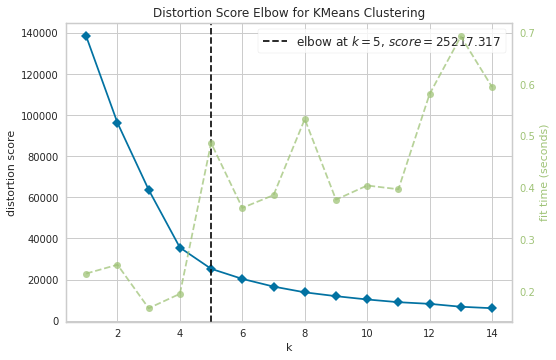

array([[3.14025382, 2.67080126, 2.60015446, 3.57629894, 1.02229052],
       [3.14025382, 2.67080126, 2.60015446, 3.57629894, 1.02229052],
       [3.14025382, 2.67080126, 2.60015446, 3.57629894, 1.02229052],
       ...,
       [2.18664607, 2.69936964, 0.37883251, 2.79635575, 3.52250692],
       [2.18664607, 2.69936964, 0.37883251, 2.79635575, 3.52250692],
       [2.18664607, 2.69936964, 0.37883251, 2.79635575, 3.52250692]])

In [16]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 15))

features_to_cluster = ["PC_1", "PC_2", "PC_3", "PC_4"]

mod_df1 = train_df[features_to_cluster + ["id"]].copy()
mod_df2 = test_df[features_to_cluster + ["id"]].copy()
mod_df1['set'] = 'train'
mod_df2['set'] = 'test'

mod_df = mod_df1.append(mod_df2)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(mod_df[features_to_cluster])

visualizer.fit(scaled_data)  # Fit the data to the visualizer
visualizer.show();

kmeans = KMeans(n_clusters=5)
kmeans.fit_transform(scaled_data)

# train_df.tail(100)

In [17]:
# # The previous k value fluctuates between 4 and 5.
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(s.fit_transform(mod_df[temp_cols]))

clusters_df = mod_df.copy()
clusters_df["cluster"] = kmeans.labels_
clusters_df

,PC_1,PC_2,PC_3,PC_4,id,set,cluster
0,-1.807271,1.514246,-2.654075,0.050869,0,train,4
1,-1.807271,1.514246,-2.654075,0.050869,1,train,4
2,-1.807271,1.514246,-2.654075,0.050869,2,train,4
3,-1.807271,1.514246,-2.654075,0.050869,3,train,4
4,-1.807271,1.514246,-2.654075,0.050869,4,train,4
...,...,...,...,...,...,...,...
9700,-1.878613,-0.773556,-1.040399,-0.044302,85457,test,2
9701,-1.878613,-0.773556,-1.040399,-0.044302,85458,test,2
9702,-1.878613,-0.773556,-1.040399,-0.044302,85459,test,2
9703,-1.878613,-0.773556,-1.040399,-0.044302,85460,test,2


In [18]:
clusters_df.groupby(["set"]).cluster.value_counts(normalize=True)

set    cluster
test   0          0.557445
       2          0.336734
       4          0.105822
train  3          0.263670
       2          0.257603
       0          0.254590
       1          0.120043
       4          0.104094
Name: cluster, dtype: float64

In [19]:
# clusters_df = clusters_df[clusters_df.columns[50:].to_list()].copy()
# clusters_df

In [20]:
train_df = train_df.merge(clusters_df[["id", "cluster"]], how='left', on='id')
test_df = test_df.merge(clusters_df[["id", "cluster"]], how='left', on='id')

In [21]:
test_df

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,direction_peak_wind_speed,max_wind_speed,days_with_fog,id,building_ID,PC_1,PC_2,PC_3,PC_4,cluster
0,7,62.186488,214.951699,244.345963,28484.0,1994.0,37.0,2.4,38,50.596774,...,NaN,NaN,NaN,75757,147.640984,-0.212016,1.765216,-3.346900,-0.142452,4
1,7,62.186488,214.951699,244.345963,21906.0,1961.0,55.0,45.7,38,50.596774,...,NaN,NaN,NaN,75758,289.311781,-0.212016,1.765216,-3.346900,-0.142452,4
2,7,62.186488,214.951699,244.345963,16138.0,1950.0,1.0,59.1,38,50.596774,...,NaN,NaN,NaN,75759,152.767192,-0.212016,1.765216,-3.346900,-0.142452,4
3,7,62.186488,214.951699,244.345963,97422.0,1971.0,34.0,35.4,38,50.596774,...,NaN,NaN,NaN,75760,269.464612,-0.212016,1.765216,-3.346900,-0.142452,4
4,7,62.186488,214.951699,244.345963,61242.0,1942.0,35.0,1.8,38,50.596774,...,330.0,22.8,126.0,75761,245.522877,-0.212016,1.765216,-3.346900,-0.142452,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,53.989234,33.831396,36.737785,305925.0,2013.0,99.0,812.0,21,38.661290,...,NaN,NaN,NaN,85457,24.101985,-1.878613,-0.773556,-1.040399,-0.044302,2
9701,7,53.989234,33.831396,36.737785,34909.0,1910.0,94.0,26.5,21,38.661290,...,NaN,NaN,NaN,85458,20.785871,-1.878613,-0.773556,-1.040399,-0.044302,2
9702,7,53.989234,33.831396,36.737785,42393.0,2014.0,94.0,812.0,21,38.661290,...,NaN,NaN,NaN,85459,37.327426,-1.878613,-0.773556,-1.040399,-0.044302,2
9703,7,53.989234,33.831396,36.737785,25368.0,1992.0,79.0,812.0,21,38.661290,...,NaN,NaN,NaN,85460,28.756324,-1.878613,-0.773556,-1.040399,-0.044302,2


In [22]:
train_df

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,max_wind_speed,days_with_fog,site_eui,id,building_ID,PC_1,PC_2,PC_3,PC_4,cluster
0,1,62.186488,214.951699,244.345963,61242.0,1942.0,11.0,2.4,36,50.500000,...,1.0,NaN,248.682615,0,245.522877,-1.807271,1.514246,-2.654075,0.050869,4
1,1,62.186488,30.883848,33.983615,274000.0,1955.0,45.0,1.8,36,50.500000,...,1.0,12.0,26.500150,1,27.609132,-1.807271,1.514246,-2.654075,0.050869,4
2,1,62.186488,72.530248,96.286952,280025.0,1951.0,97.0,1.8,36,50.500000,...,1.0,12.0,24.693619,2,23.481589,-1.807271,1.514246,-2.654075,0.050869,4
3,1,62.186488,72.198760,70.729325,55325.0,1980.0,46.0,1.8,36,50.500000,...,1.0,12.0,48.406926,3,43.272466,-1.807271,1.514246,-2.654075,0.050869,4
4,1,62.186488,30.883848,22.552326,66000.0,1985.0,100.0,2.4,36,50.500000,...,1.0,NaN,3.899395,4,5.196438,-1.807271,1.514246,-2.654075,0.050869,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24886,6,53.989234,68.953447,67.477251,20410.0,1995.0,8.0,36.6,28,43.451613,...,NaN,NaN,132.918411,75752,115.851934,-2.582196,-0.621382,-1.913257,-0.163417,2
24887,6,53.989234,33.831396,36.737785,40489.0,1910.0,98.0,36.6,28,43.451613,...,NaN,NaN,39.483672,75753,39.483672,-2.582196,-0.621382,-1.913257,-0.163417,2
24888,6,53.989234,101.929445,100.686895,28072.0,1917.0,NaN,36.6,26,36.612903,...,NaN,NaN,48.404398,75754,45.288971,-4.491773,-1.369880,-0.363621,0.025101,2
24889,6,53.989234,101.929445,100.686895,53575.0,2012.0,NaN,36.6,26,36.612903,...,NaN,NaN,592.022750,75755,568.556627,-4.491773,-1.369880,-0.363621,0.025101,2


In [23]:
# Figuring out the examples for which we could not find building_ID.

filter_num = [isinstance(test_df.building_ID.values[i], float) for i in
              range(test_df.shape[0])]
filter_str = [isinstance(test_df.building_ID.values[i], str) for i in
              range(test_df.shape[0])]
test_num = test_df[filter_num].copy()
test_str = test_df[filter_str].copy()

#### Here, instead of fitting another model on the test set rows for which we cannot find buidling_ID, I'm setting building_ID as missing values and allowing IterativeImputer to do its magic. This is a workaround to avoid using two models for two subsets of test set.

In [24]:
test_df.loc[filter_str, 'building_ID'] = None

In [25]:
test_df

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,direction_peak_wind_speed,max_wind_speed,days_with_fog,id,building_ID,PC_1,PC_2,PC_3,PC_4,cluster
0,7,62.186488,214.951699,244.345963,28484.0,1994.0,37.0,2.4,38,50.596774,...,NaN,NaN,NaN,75757,147.640984,-0.212016,1.765216,-3.346900,-0.142452,4
1,7,62.186488,214.951699,244.345963,21906.0,1961.0,55.0,45.7,38,50.596774,...,NaN,NaN,NaN,75758,289.311781,-0.212016,1.765216,-3.346900,-0.142452,4
2,7,62.186488,214.951699,244.345963,16138.0,1950.0,1.0,59.1,38,50.596774,...,NaN,NaN,NaN,75759,152.767192,-0.212016,1.765216,-3.346900,-0.142452,4
3,7,62.186488,214.951699,244.345963,97422.0,1971.0,34.0,35.4,38,50.596774,...,NaN,NaN,NaN,75760,269.464612,-0.212016,1.765216,-3.346900,-0.142452,4
4,7,62.186488,214.951699,244.345963,61242.0,1942.0,35.0,1.8,38,50.596774,...,330.0,22.8,126.0,75761,245.522877,-0.212016,1.765216,-3.346900,-0.142452,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,53.989234,33.831396,36.737785,305925.0,2013.0,99.0,812.0,21,38.661290,...,NaN,NaN,NaN,85457,24.101985,-1.878613,-0.773556,-1.040399,-0.044302,2
9701,7,53.989234,33.831396,36.737785,34909.0,1910.0,94.0,26.5,21,38.661290,...,NaN,NaN,NaN,85458,20.785871,-1.878613,-0.773556,-1.040399,-0.044302,2
9702,7,53.989234,33.831396,36.737785,42393.0,2014.0,94.0,812.0,21,38.661290,...,NaN,NaN,NaN,85459,37.327426,-1.878613,-0.773556,-1.040399,-0.044302,2
9703,7,53.989234,33.831396,36.737785,25368.0,1992.0,79.0,812.0,21,38.661290,...,NaN,NaN,NaN,85460,28.756324,-1.878613,-0.773556,-1.040399,-0.044302,2


### ML Pipeline

In [26]:
features_selected = [
    "facility_type",
    "building_class",
    "year_built",
    "floor_area",
    "energy_star_rating",
    "State_Factor",
    "building_ID",
    "PC_1",
    "PC_2",
    "PC_3",
    "PC_4",
    "Year_Factor"
#     "Year_Factor",
#     "cluster"
   # "month_ID"
]
target = "site_eui"
drop_features = list(
    set(train_df.columns) - set(features_selected) - {target} - {"Year_Factor"}
    #- set(single)
)

In [27]:
impute_estimator = ExtraTreesRegressor(random_state=1, n_estimators=200)

column_transformer = make_column_transformer(
    (IterativeImputer(random_state=1, estimator=impute_estimator), features_selected),
    # (StandardScaler(), features_selected),
#     ("passthrough", features_selected),
    ("drop", drop_features)
)

In [28]:
# impute_estimator = ExtraTreesRegressor(random_state=1, n_estimators=200)
# imputer = IterativeImputer(random_state=1, estimator=impute_estimator)

# train_df["building_ID"] = imputer.fit_transform(train_df[features_selected])[:, -2]
# test_df["building_ID"] = imputer.transform(test_df[features_selected])[:, -2]

In [29]:
# Since, MLPRegresoor is a neural net, scaling is required in the pipeline. (already implemented)

scaler = StandardScaler()

regressor = MLPRegressor(
    random_state=1,
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.013,
    early_stopping=True,
    hidden_layer_sizes=(200, 200),
    max_iter=10000,
    momentum=0.9697,
)

In [30]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring_metric = make_scorer(root_mean_squared_error)
results = {}

model = VotingRegressor(
    [
        (
            'cat', CatBoostRegressor(
                iterations=5000,
                grow_policy='Lossguide',
                verbose=0,
                task_type='GPU',
                l2_leaf_reg=1,
                learning_rate=0.03,
                depth=10,
            )
        ),
        (
            'xgb', XGBRegressor(
                grow_policy='lossguide',
                tree_method='gpu_hist',
                n_estimators=5000,
                eta=0.05, 
                max_depth=10,
                reg_lambda=1
            )
        ),
        (
            'lgbm', LGBMRegressor(
                n_estimators=10000, # num_iterations
                device="gpu",
                learning_rate=0.03,
                reg_lambda=5,
                num_leaves=25,
            )
        ),
        (
            'mlp', make_pipeline(scaler, regressor) # new model added
        )
    ]
)

model_pipe = make_pipeline(
    column_transformer,
    model
)

# Using KFold instead of CV

In [31]:
from sklearn.model_selection import StratifiedKFold

folds=5
skf = StratifiedKFold(n_splits=folds)

X_pre, year_factor = train_df, train_df["Year_Factor"]

X, y = X_pre.drop("site_eui", axis=1), X_pre["site_eui"]

X.info()

# predictions = np.zeros(test_df.shape[0])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24891 entries, 0 to 24890
Data columns (total 69 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                24891 non-null  int64  
 1   State_Factor               24891 non-null  float64
 2   building_class             24891 non-null  float64
 3   facility_type              24891 non-null  float64
 4   floor_area                 24891 non-null  float64
 5   year_built                 23887 non-null  float64
 6   energy_star_rating         18349 non-null  float64
 7   ELEVATION                  24891 non-null  float64
 8   january_min_temp           24891 non-null  int64  
 9   january_avg_temp           24891 non-null  float64
 10  january_max_temp           24891 non-null  int64  
 11  february_min_temp          24891 non-null  int64  
 12  february_avg_temp          24891 non-null  float64
 13  february_max_temp          24891 non-null  int

In [32]:
import timeit

train_score = 0
valid_score = 0

fold = 1
for train_index, valid_index in skf.split(X_pre, year_factor):
    
    print(f"fold = {fold}, train set size: {len(train_index)}, valid set size: {len(valid_index)}")
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    start = timeit.default_timer()
    model_pipe.fit(X_train, y_train)
    
    fold_train_score = root_mean_squared_error(y_train, model_pipe.predict(X_train))
    fold_valid_score = root_mean_squared_error(y_valid, model_pipe.predict(X_valid))
    print(f"Train Score: {fold_train_score}")
    print(f"Valid Score: {fold_valid_score}")
    
    train_score += fold_train_score
    valid_score += fold_valid_score
    
    # predictions =  np.add(predictions, model_pipe.predict(test_df))
    end = timeit.default_timer()
    print(f"time taken = {round(end-start)} seconds.")
    fold += 1
    print("\n")
print(f"mean train score = {train_score/folds}, mean valid score = {valid_score/folds}")

fold = 1, train set size: 19912, valid set size: 4979
Train Score: 5.696278121037831
Valid Score: 12.110763851652447
time taken = 380 seconds.


fold = 2, train set size: 19913, valid set size: 4978
Train Score: 3.1604161254660306
Valid Score: 14.40447785868267
time taken = 313 seconds.


fold = 3, train set size: 19913, valid set size: 4978
Train Score: 5.7197808031408535
Valid Score: 11.284828356644331
time taken = 308 seconds.


fold = 4, train set size: 19913, valid set size: 4978
Train Score: 5.79072845703851
Valid Score: 11.955341082500581
time taken = 303 seconds.


fold = 5, train set size: 19913, valid set size: 4978
Train Score: 5.855966338840873
Valid Score: 8.929015817971928
time taken = 302 seconds.


mean train score = 5.24463396910482, mean valid score = 11.736885393490393


#### On it's own, MLPRegressor gives excellent validation scores of below 10, but it could be due to overfit on validation set. In it's implementation, I have used early_stopping which does not allow validation score to shoot up during backpropagation.

### Submission

In [33]:
model_pipe.fit(X, y);

In [34]:
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "site_eui": model_pipe.predict(test_df)
})

In [35]:
submission_df.to_csv("/kaggle/working/submission-sj.csv", index=False)